## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from feature_engine.outliers import OutlierTrimmer



DATA_DIR = 'data'

## Load relevant dataframes

In [2]:
activities = pd.read_csv(f'{DATA_DIR}/activity.csv')
all_scores = pd.read_csv(f'{DATA_DIR}/all_scores.csv')

In [3]:
activities = activities[['user_id', 'course_id', 'activity_type', 'activity_started', 'activity_completed']]
all_scores = all_scores[['user_id', 'course', 'percentage']]

### Remove old dates, outliers, long  and missing durations

In [4]:
activities = activities[activities['course_id'].isin(all_scores.course.unique())]
# Drop irrelevant activity types
activities = activities[~activities['activity_type'].isin(['exam','group_progress','access'])]

activities = activities.dropna(subset=['activity_started', 'activity_completed'])
activities['activity_started'] = pd.to_datetime(activities['activity_started'], unit='s')
activities['activity_completed'] = pd.to_datetime(activities['activity_completed'], unit='s')
activities['duration'] = activities['activity_completed'] - activities['activity_started']

print(activities.shape)
activities = activities[
    (activities['duration'] >= pd.Timedelta(0)) &
    (activities['duration'] <= pd.Timedelta(hours=24)) &
    (activities['activity_started'].dt.year > 2022)
]
print(activities.shape)

activities['duration_minutes'] = activities['duration'].dt.total_seconds()/60

activities_before = activities.copy()
trimmer = OutlierTrimmer(capping_method='iqr', tail='both', fold=1.5, variables=['duration_minutes'])
activities = trimmer.fit_transform(activities)

print(activities.shape)

(36894, 6)
(23001, 6)
(19929, 7)


In [5]:
activities.describe()

,user_id,course_id,activity_started,activity_completed,duration,duration_minutes
count,19929.000000,19929.000000,19929,19929,19929,19929.000000
mean,2259.083396,2705.129409,2024-11-09 08:55:48.275728640,2024-11-09 09:05:20.817351680,0 days 00:09:32.541622760,9.542360
min,1.000000,42.000000,2023-04-07 16:42:38,2023-04-07 16:43:58,0 days 00:00:02,0.033333
25%,329.000000,42.000000,2024-10-09 10:20:32,2024-10-09 10:30:18,0 days 00:00:54,0.900000
50%,3182.000000,3301.000000,2024-11-14 17:49:04,2024-11-14 17:57:28,0 days 00:04:24,4.400000
75%,3881.000000,3865.000000,2025-01-01 15:58:53,2025-01-01 16:01:31,0 days 00:13:19,13.316667
max,4095.000000,5447.000000,2025-03-07 06:42:09,2025-03-07 06:57:30,0 days 00:55:52,55.866667
std,1721.925101,1972.971233,NaN,NaN,0 days 00:12:11.166207416,12.186103


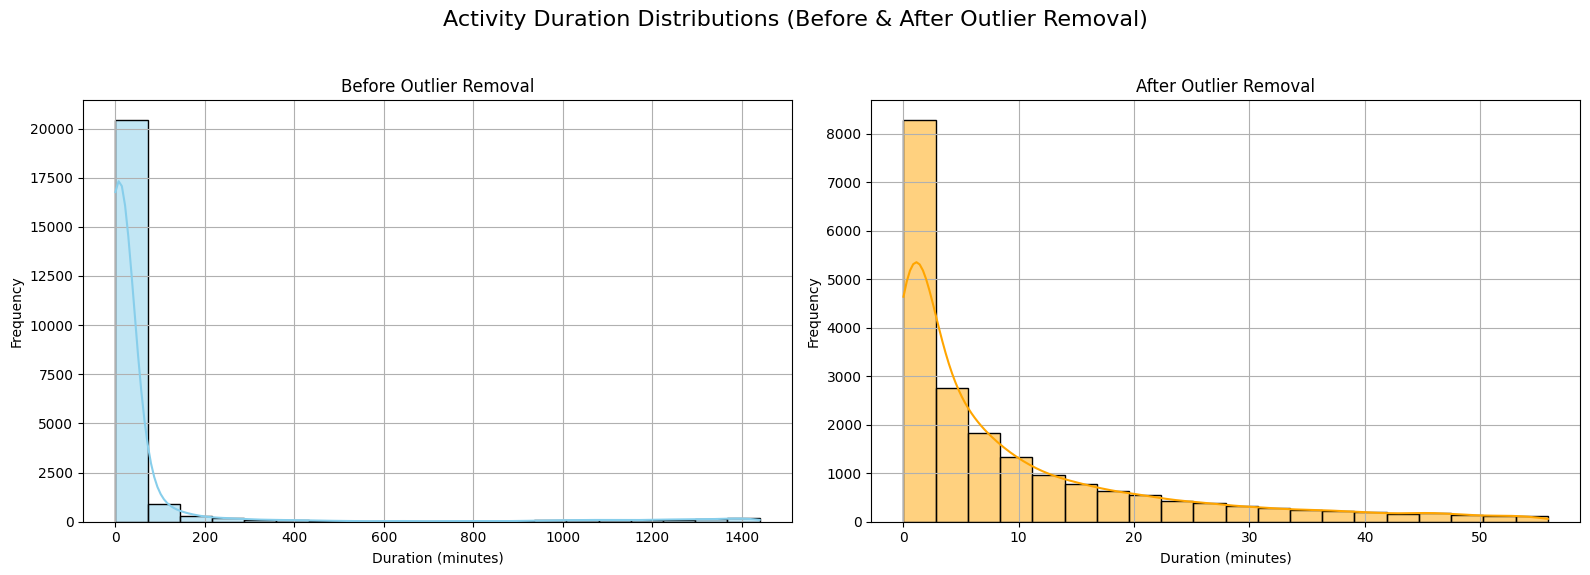

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Activity Duration Distributions (Before & After Outlier Removal)", fontsize=16)

sns.histplot(activities_before['duration_minutes'], bins=20, color='skyblue', ax=axes[0], kde=True)
axes[0].set_title('Before Outlier Removal')
axes[0].set_xlabel('Duration (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

sns.histplot(activities['duration_minutes'], bins=20, color='orange', ax=axes[1], kde=True)
axes[1].set_title('After Outlier Removal')
axes[1].set_xlabel('Duration (minutes)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Calculate zscores on a per course basis, keep percentages for visualizations

In [7]:
df = all_scores.copy()
df["zscore"] = df.groupby("course")["percentage"].transform(lambda x: (x - x.mean()) / x.std(ddof=0))
zscores = df.rename(columns={'course': 'course_id'})

zscores.describe()

,user_id,course_id,percentage,zscore
count,6432.000000,6432.000000,6432.000000,6.432000e+03
mean,2420.168999,2894.153141,56.098510,-1.115747e-16
std,1698.985735,2011.163854,29.366960,1.000078e+00
min,1.000000,42.000000,0.000000,-5.423334e+00
25%,332.000000,42.000000,36.099727,-6.343278e-01
50%,3503.000000,3865.000000,62.500000,2.908645e-02
75%,3932.000000,3865.000000,78.000000,7.789549e-01
max,4095.000000,5447.000000,100.000000,3.370601e+00


In [8]:
# Create mapping course_id -> course name/short name

class SmartMap(dict):
    def __missing__(self, key):
        return f"Unknown({key})"
    
course_map = SmartMap({
    42 : 'Langzeitgymnasium maths',
    3865 : 'Kurzzeitgymnasium maths',
    5447 : 'Langzeitgymnasium essay',
    2115 : 'Langzeitgymnasium text comprehension',
    5009 : 'Kurzzeitgymnasium text comprehension',
    3301 : 'Kurzzeitgymnasium essay',
    1696 : 'Student site introduction',
    8117 : 'Teacher site introduction'
})

course_map_short = SmartMap({
    42 : 'LZG_M',
    3865 : 'KZG_M',
    5447 : 'LZG_E',
    2115 : 'LZG_TC',
    5009 : 'KZG_TC',
    3301 : 'KZG_E',
    1696 : 'SSI',
    8117 : 'TSI'
})

## Cook some dataframes for analysis

In [9]:
course_median_duration = activities.groupby(['course_id', 'activity_type'])['duration'].median().reset_index()
print(course_median_duration)

    course_id activity_type               duration
0          42        lesson 0 days 00:11:48.500000
1          42          quiz 0 days 00:05:07.500000
2          42         topic        0 days 00:02:02
3        2115        lesson        0 days 00:03:42
4        2115         topic 0 days 00:01:54.500000
5        3301        lesson        0 days 00:18:01
6        3301          quiz 0 days 00:03:50.500000
7        3301         topic        0 days 00:06:39
8        3865        lesson        0 days 00:07:58
9        3865          quiz        0 days 00:10:47
10       3865         topic        0 days 00:04:05
11       5009        lesson        0 days 00:14:07
12       5009         topic        0 days 00:03:45
13       5447        lesson        0 days 00:11:05
14       5447          quiz 0 days 00:02:56.500000
15       5447         topic        0 days 00:05:05


In [16]:
# GPT-generated visualization

def plot_course_durations(df_median, course_map_short):
    # Prepare the data
    df_median = df_median.copy()
    df_median['duration_sec'] = df_median['duration'].dt.total_seconds()
    
    total_durations = df_median.groupby('course_id')['duration_sec'].sum()
    max_total_duration = total_durations.max()

    # Color map for activities
    activity_types = sorted(df_median['activity_type'].unique())
    cmap = plt.get_cmap('Set2')
    colors = cmap(np.linspace(0, 1, len(activity_types)))
    color_map = dict(zip(activity_types, colors))

    # Plot settings
    courses = total_durations.sort_values(ascending=False).index
    n_courses = len(courses)
    n_cols = 3
    n_rows = int(np.ceil(n_courses / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
    axes = axes.flatten()

    for idx, course_id in enumerate(courses):
        ax = axes[idx]
        course_data = df_median[df_median['course_id'] == course_id]
        durations = course_data['duration_sec'].values
        labels = course_data['activity_type'].values

        total_duration = durations.sum()
        course_fraction = total_duration / max_total_duration
        max_angle = 360 * course_fraction  # Total filled angle for this course

        # Compute sizes in angles instead of fractions of 1
        sizes = durations / total_duration * max_angle

        start_angle = 90
        for label, size in zip(labels, sizes):
            ax.pie(
                [size, 360 - size], 
                colors=[color_map[label], (0, 0, 0, 0)],  # Transparent for remaining part
                startangle=start_angle, 
                radius=1,
                counterclock=False,
                wedgeprops=dict(width=0.3, edgecolor='white')
            )
            start_angle -= size  # Update start angle for next segment

        # Draw the remaining transparent gap (optional light gray)
        if course_fraction < 1:
            ax.pie(
                [360 * (1 - course_fraction), 360 * course_fraction],
                colors=['#f0f0f0', (0, 0, 0, 0)],
                startangle=90 - max_angle,
                radius=1,
                counterclock=False,
                wedgeprops=dict(width=0.3, edgecolor='white')
            )

        # Add center text
        course_name = course_map_short.get(course_id, course_id)
        total_hours = int(total_duration // 3600)
        total_minutes = int((total_duration % 3600) // 60)
        ax.text(0, 0.1, course_name, ha='center', va='center', fontsize=12, weight='bold')
        ax.text(0, -0.1, f"{total_hours}h {total_minutes}m", ha='center', va='center', fontsize=10)
        
        ax.set_aspect('equal')
        ax.axis('off')
    
    # Remove unused subplots
    for j in range(idx + 1, len(axes)):
        axes[j].axis('off')

    # Add Legend
    legend_patches = [mpatches.Patch(color=color_map[act], label=act) for act in activity_types]
    fig.legend(
        handles=legend_patches, 
        loc='upper right', 
        fontsize=10, 
        title='Activity Types'
    )
    plt.title("Course Durations", fontsize=16, loc='center')

    
    plt.tight_layout()
    plt.show()


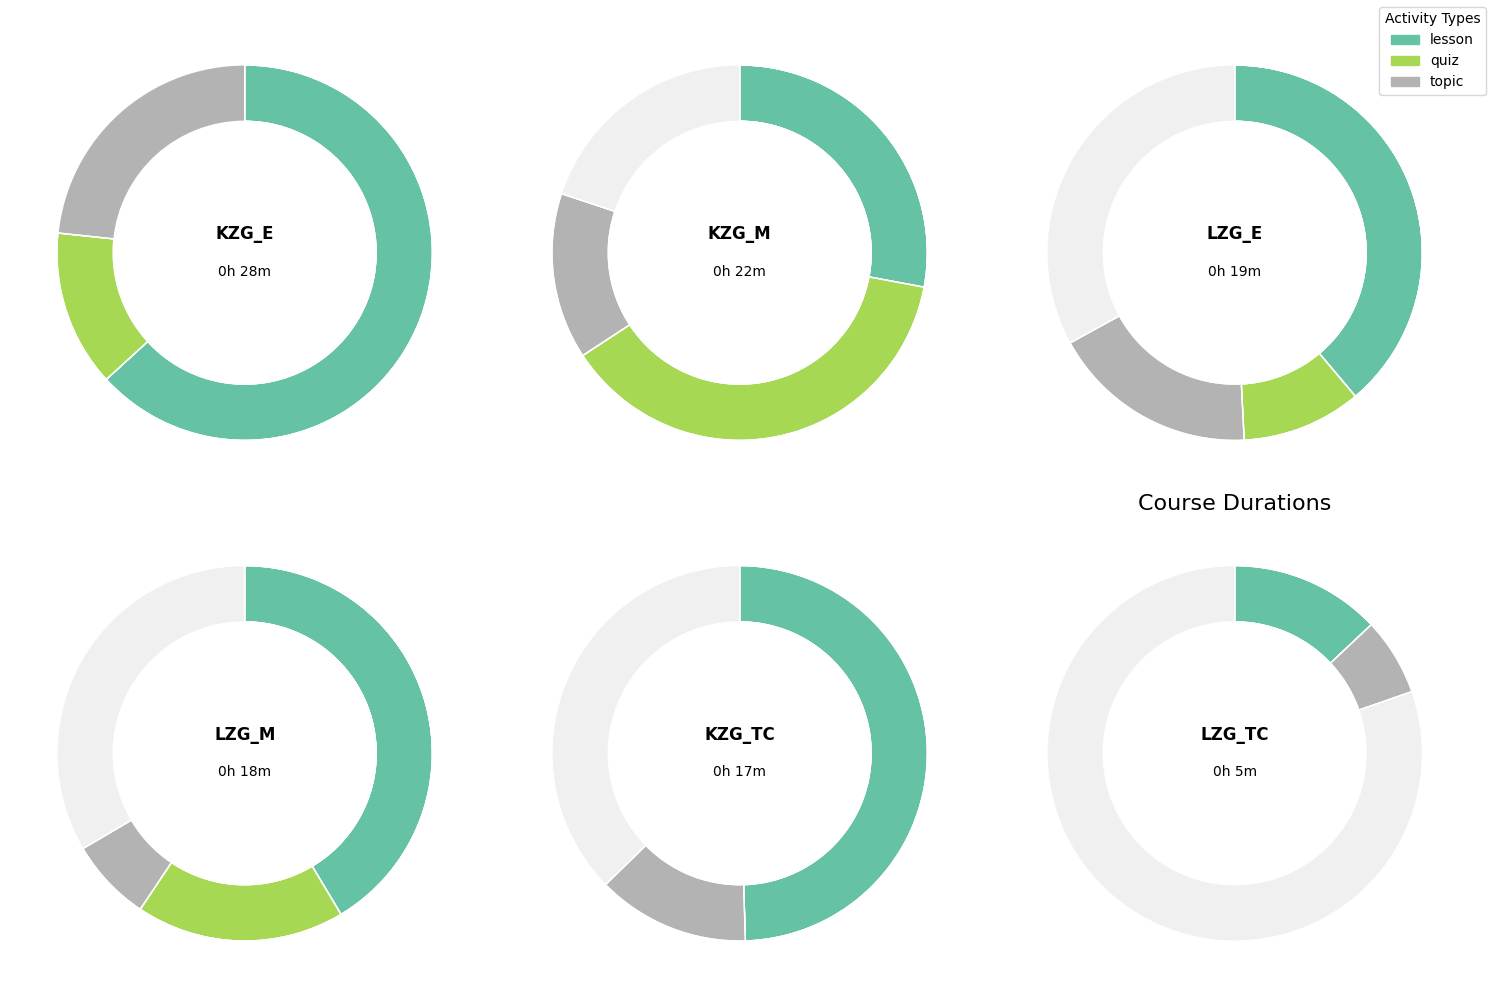

In [17]:
plot_course_durations(course_median_duration, course_map_short)

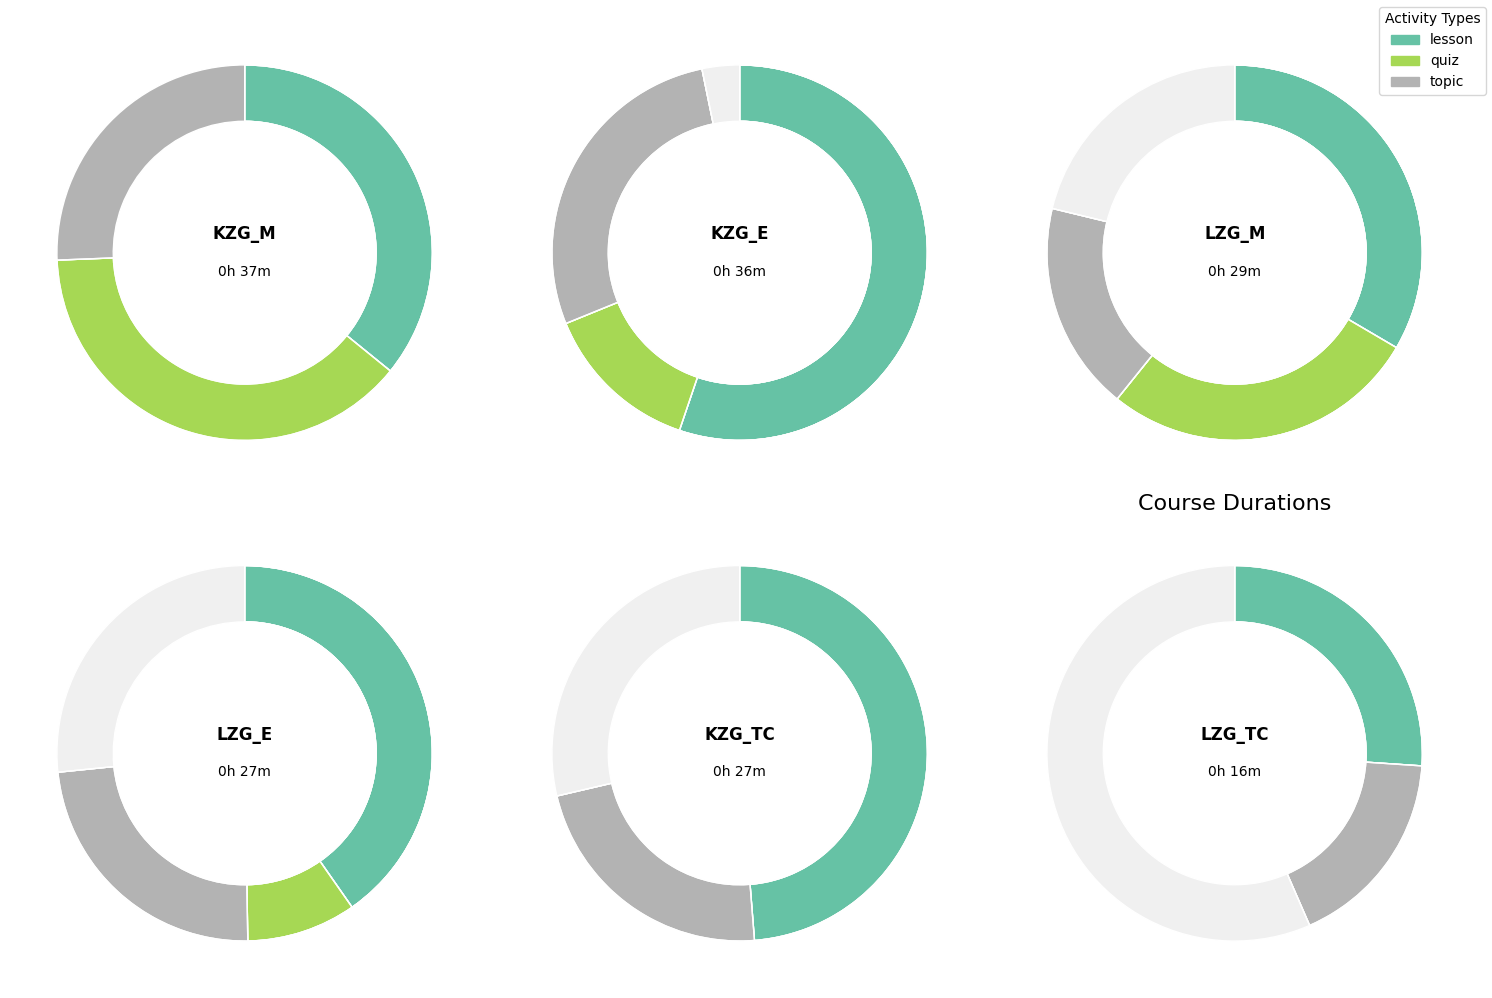

In [18]:
plot_course_durations(activities.groupby(['course_id', 'activity_type'])['duration'].mean().reset_index(), course_map_short)

In [12]:
course_median_duration.activity_type.unique()

array(['lesson', 'quiz', 'topic'], dtype=object)

In [13]:


def compute_learning_speed(user_data: pd.DataFrame, global_median: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the normalized learning speed metric per user.

    Parameters:
    - user_data: DataFrame with columns course_id', 'activity_duration'] (timedelta64).
    - global_median: DataFrame with columns ['course_id', 'median_duration'] (timedelta64).

    Returns:
    - DataFrame with ['user_id', 'final_learning_speed'] where values are in [0, 1], higher is faster.
    """
    total_states = global_median['course_id'].nunique()

    # Compute per-user, per-state median durations
    user_state_medians = (
        user_data
        .groupby(['user_id', 'course_id'])['activity_duration']
        .median()
        .reset_index()
    )

    # Merge with global medians
    merged = user_state_medians.merge(global_median, on='course_id')

    # Compute duration ratio and learning speed
    merged['duration_ratio'] = merged['activity_duration'] / merged['median_duration']
    merged['learning_speed'] = 1 / (1 + merged['duration_ratio'])

    # Compute learning speed sum and number of states experienced per user
    user_scores = merged.groupby('user_id').agg(
        learning_speed_sum=('learning_speed', 'sum'),
        states_experienced=('course_id', 'nunique')
    ).reset_index()

    # Apply normalization adjusted for missing states (assuming avg speed = 0.5 for missing states)
    user_scores['final_learning_speed'] = (
        (user_scores['learning_speed_sum'] + 0.5 * (total_states - user_scores['states_experienced'])) 
        / total_states
    )

    return user_scores[['user_id', 'final_learning_speed']]


